In [1]:
pip install xlrd


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [123]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDClassifier
import statsmodels.api as sm

In [124]:
df = pd.read_excel('ВР_МБ_месячные_среднедневные.xls')

df = df.drop(0)
df.columns = df.iloc[0]
df = df.drop(1)
df_1 = df.copy()

df_1 = df_1[['Месяц', 'Валютный рынок, всего','USDRUB, всего']]
df_1['Валютный рынок, всего'] = pd.to_numeric(df_1['Валютный рынок, всего'])

df_1['USDRUB, всего'] = pd.to_numeric(df_1['USDRUB, всего'])
df_1['Доля доллара'] = df_1['USDRUB, всего']/df_1['Валютный рынок, всего']

Доллар обеспечивает лёгкость и быстроту проведения операций за счёт высокой ликвидности. Снижение доли доллара затруднит проведение операций из-за чего объём торгов снизится. 

In [125]:
df_1 = df_1[:255].reset_index()

ref_rows = df_1.loc[df_1['Месяц'] == '#REF!']
df_1 = df_1.drop(ref_rows.index)

df_1['Месяц'] = pd.to_datetime(df_1['Месяц'],  dayfirst=True)
df_1 = df_1.rename(columns={"Месяц":"Дата"})
del df_1['index']

C:\Users\Артем\AppData\Local\Temp\ipykernel_36588\1604730270.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_1['Месяц'] = pd.to_datetime(df_1['Месяц'],  dayfirst=True)


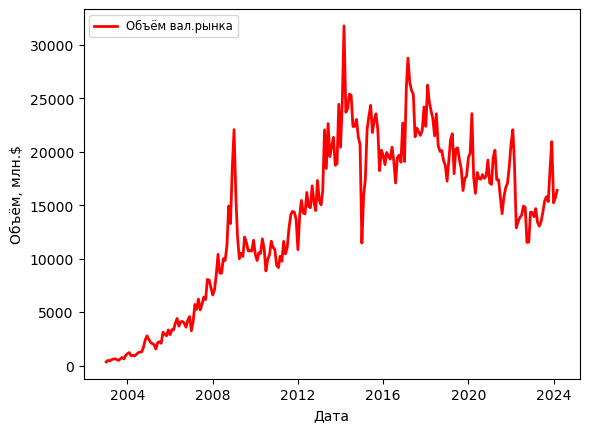

In [126]:
plt.plot(df_1['Дата'], df_1['Валютный рынок, всего'], color='red', linewidth=2, label='Объём вал.рынка')

plt.xlabel('Дата')
plt.ylabel('Объём, млн.$')
plt.legend(loc='upper left', fontsize='small')

In [127]:
smena = df_1[df_1['Дата'] == '2014-12-01'].index[0]

a = np.ones(smena, dtype = int)
b = np.zeros(255-smena, dtype = int)
x = np.hstack([a,b])

df_1['Фикс. вал. курс'] = x

Смена режима валютного курса - при наличии валютного коридора ЦБ проводит валютные интервенции для поддержания курса, продавая или покупая официальные резервы, что увеличивает объем рынка. При плавающем валютном курсе объем рынка увеличивается из-за роста числа спекуляций и хеджирования валютного риска. 

In [128]:
def correct_values(value: str):

    corrected_value = value.replace('.', '')
    corrected_value = corrected_value.replace(',', '.')
    corrected_value = corrected_value.replace('%', '')
    corrected_value = corrected_value.replace('B', '')
    corrected_value = corrected_value.replace('M', '')
    corrected_value = corrected_value.replace('K', '')
    corrected_value = float(corrected_value)

    if 'B' in value:
        corrected_value *= 10**9 
    elif 'M' in value: 
        corrected_value *= 10**6   
    elif 'K' in value: 
        corrected_value *= 10**3  

    return corrected_value

In [129]:
df_2 = pd.read_csv('Нефть - Лист1.csv')

df_2['Объём'] = df_2['Объём'].map(correct_values, na_action='ignore')

df_2['Дата'] = pd.to_datetime(df_2['Дата'],  dayfirst=True)

df_merged = df_1.merge(df_2, how='left', on='Дата')
df_merged = df_merged.rename(columns = {'Цена':'Цена нефти, $','Объём' : 'Объём, бар.'})

df_merged['Цена нефти, $'] = df_merged['Цена нефти, $'].map(correct_values, na_action='ignore')
df_merged['ценахобъем'] = df_merged['Цена нефти, $'] * df_merged['Объём, бар.']
df_merged = df_merged[:254]

Нефть - рост объёма торгов нефти увеличивает доходы национальных экспортеров, что заставляет их по новому бюджетному правилу обменивать часть выручки на иностранную валюту и наоборот


In [130]:
df_3 = pd.read_csv('доллар.csv')

del df_3['Откр.']
del df_3['Макс.']
del df_3['Мин.']

df_3 = df_3.rename(columns={"Цена":"Курс USDRUB"})
df_3['Дата'] = pd.to_datetime(df_3['Дата'],  dayfirst=True)
df_3['Курс USDRUB'] = df_3['Курс USDRUB'].map(correct_values, na_action='ignore')

df_3['Месяц'] = df_3['Дата'].dt.month
df_3['Год'] = df_3['Дата'].dt.year

meann = df_3.groupby(['Год', 'Месяц'])['Курс USDRUB'].mean()
stdd = df_3.groupby(['Год', 'Месяц'])['Курс USDRUB'].std()

b = pd.DataFrame(data=meann.index, columns=['Дата']) 
c = pd.DataFrame(data=meann.values, columns=['Средний курс'])
meann = pd.merge(b, c, left_index=True, right_index=True)

a = pd.DataFrame(data=stdd.index, columns=['Дата']) 
d = pd.DataFrame(data=stdd.values, columns=['Волатильность курса'])
stdd = pd.merge(a, d, left_index=True, right_index=True)

meann['Дата'] = meann['Дата'].apply(lambda x: datetime(x[0], x[1], 1).strftime('%Y-%m-%d'))
meann['Дата'] = meann['Дата'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))

stdd['Дата'] = stdd['Дата'].apply(lambda x: datetime(x[0], x[1], 1).strftime('%Y-%m-%d'))
stdd['Дата'] = stdd['Дата'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))

df_merged = df_merged.merge(meann[:255], how='left', on='Дата')
df_merged = df_merged.merge(stdd[:255], how='left', on='Дата')

Средний курс и волатильность - рост обратного курса USD/RUB увеличивает привлекательность инвестирования для нерезидентов, что способствует росту объема валютного рынка


In [131]:
df_merged['ценахобъемхруб'] = df_merged['Средний курс'] * df_merged['ценахобъем']

Привели в рубль

In [132]:
last_two_rows_index = df_merged.index[-2:]
df_merged = df_merged.drop(last_two_rows_index)

In [133]:
df_4 = pd.read_csv('инфляцияяяяя.csv', sep=';')

df_4['Инфляция'] = df_4['Инфляция'].map(correct_values, na_action='ignore')
df_4['Инфляция'] = pd.to_numeric(df_4['Инфляция'], errors='coerce')
df_4['Дата'] = pd.to_datetime(df_4['Дата'],  dayfirst=True)

df_merged = df_merged.merge(df_4, how='left', on='Дата')

Инфляция - рост уровня цен в стране побуждает инвесторов вкладываться в иностранную валюту, которая в меньшей степени подвержена инфляции

In [134]:
#Убираем промежуточные факторы и переименовываем
del df_merged['USDRUB, всего']
del df_merged['ценахобъем']
del df_merged['Цена нефти, $']
del df_merged['Объём, бар.']

df_merged = df_merged.rename(columns={'Валютный рынок, всего': 'Объём вал рынка, $'})
df_merged = df_merged.rename(columns={'Средний курс': 'Курс USD/RUB'})
df_merged = df_merged.rename(columns={'ценахобъемхруб': 'Объём торгов нефти, ₽'})
df_merged = df_merged.rename(columns={'Инфляция_x': 'Инфляция, %'})
df_merged = df_merged.rename(columns={'Волатильность курса': 'Волатильность USD/RUB'})

In [135]:
df_5 = pd.read_csv('индекс моекс - Лист1.csv')

df_5['Цена'] = df_5['Цена'].map(correct_values, na_action='ignore')
df_5['Цена'] = pd.to_numeric(df_5['Цена'], errors='coerce')
df_5['Дата'] = pd.to_datetime(df_5['Дата'],  dayfirst=True)

df_merged = df_merged.merge(df_5, how='left', on='Дата')

df_merged = df_merged.rename(columns={'Цена': 'Индекс моекс'})

Рост значения индекса может отражать улучшение экономической обстановки в стране, который приводит к притоку иностранных инвесторов.

In [136]:
df_6 = pd.read_csv('ипц.csv')

df_6['ИПЦ'] = df_6['ИПЦ'].map(correct_values, na_action='ignore')
df_6['ИПЦ'] = pd.to_numeric(df_6['ИПЦ'], errors='coerce')
df_6['Дата'] = pd.to_datetime(df_6['Дата'],  dayfirst=True)

df_merged = df_merged.merge(df_6, how='left', on='Дата')

df_merged['Уровень цен'] = 1  # Начальное значение для первой строки
for i in range(1, len(df_merged)):
    df_merged.at[i, 'Уровень цен'] = df_merged.at[i-1, 'Уровень цен'] * df_merged.at[i, 'ИПЦ'] / 100

df_merged['Реальный индекс моекс'] = df_merged['Индекс моекс'] / df_merged['Уровень цен']

Реальный индекс IMOEX - с поправкой на изменение уровня цен получился индекс, который отражает рост акций независимый от инфляции, показывая относительную привлекательность фондового рынка.

In [137]:
df_7 = pd.read_csv('импорттт.csv', sep=';')

df_7['Дата'] = pd.to_datetime(df_7['Дата'],  dayfirst=True)
df_7['Импорт'] = df_7['Импорт'].map(correct_values, na_action='ignore')
df_7['Импорт'] = pd.to_numeric(df_7['Импорт'], errors='coerce')

df_merged = df_merged.merge(df_7, how='left', on='Дата')

df_merged['Импорт, ₽'] = df_merged['Импорт'] * df_merged['Курс USD/RUB']

In [138]:
#del df_merged['Импорт']
del df_merged['ИПЦ']
del df_merged['Инфляция']

Импорт - рост импорта ведет к большему объему обмена валют тем самым увеличивая объём рынка валют.

In [139]:
df_8 = pd.read_csv('Balance of Trade(3).csv', sep=';')

df_8['Торговый баланс'] = df_8['Торговый баланс'].map(correct_values, na_action='ignore')
df_8['Торговый баланс'] = pd.to_numeric(df_8['Торговый баланс'], errors='coerce')
df_8['Дата'] = pd.to_datetime(df_8['Дата'],  dayfirst=True)

df_merged = df_merged.merge(df_8, how='left', on='Дата')

Торговый баланс - влияет на приток и отток капитала в страну. Положительный торговый баланс может увеличить доверие инвесторов и стимулировать приток капитала, что может увеличить объем валютного рынка.

In [140]:
df_9 = pd.read_csv('Новая таблица - Лист1 (2).csv')

df_9['ЗВР'] = df_9['ЗВР'].map(correct_values, na_action='ignore')
df_9['Дата'] = pd.to_datetime(df_9['Дата'], dayfirst = True)
df_9['Год-Месяц'] = df_9['Дата'].dt.strftime('%Y-%m')

o_r = df_9.groupby('Год-Месяц')['ЗВР'].mean()
o_r = pd.DataFrame(o_r, columns = [ 'ЗВР']).reset_index().rename(columns ={'Год-Месяц':'Дата'})
o_r['Дата'] = pd.to_datetime(o_r['Дата'])

df_merged = df_merged.merge(o_r, how = 'left', on = 'Дата')


ЗВР - изменение золотовалютных резервов Центральным Банком увеличивает объём валютного рынка, а высокие значения резервов могут повысить доверие инвесторов и спрос на национальную валюту.

In [141]:
df_merged = df_merged.rename(columns={'Импорт': 'Импорт, $'})
df_merged = df_merged.rename(columns={'Торговый баланс': 'Торговый баланс, $'})
df_merged = df_merged.rename(columns={'ЗВР': 'ЗВР, $'})

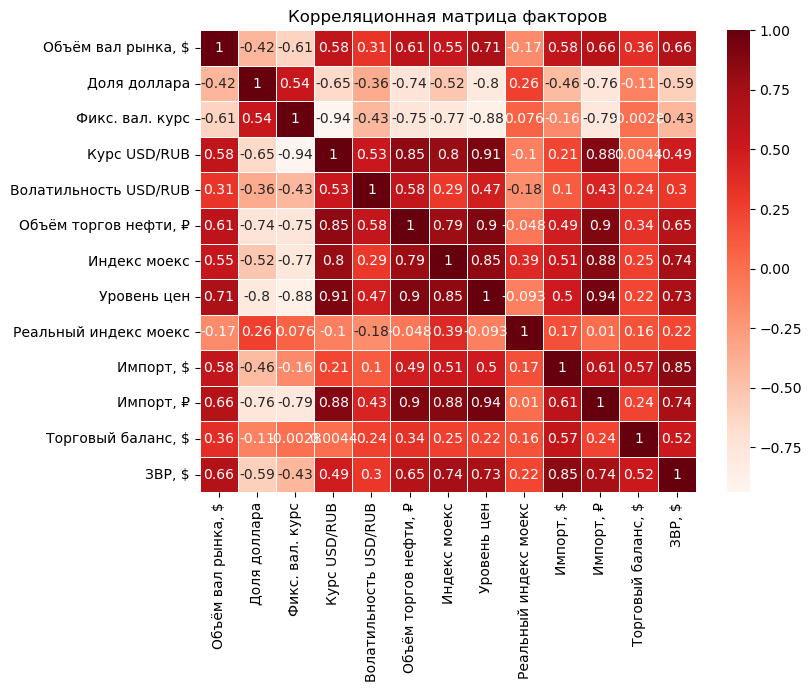

In [142]:
df_without_date = df_merged.drop(columns=['Дата'])
correlation_matrix = df_without_date.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', linewidths=.5)
plt.title('Корреляционная матрица факторов')

plt.show()

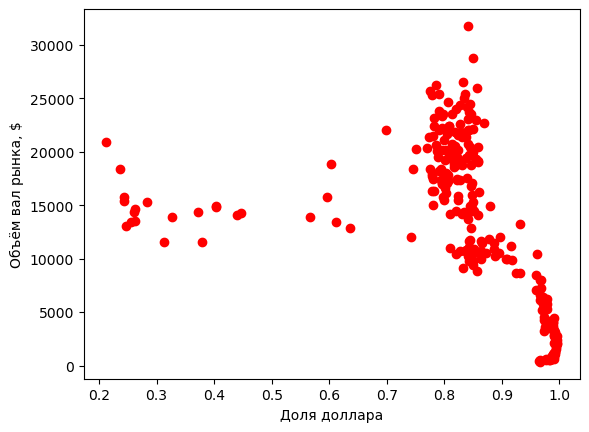

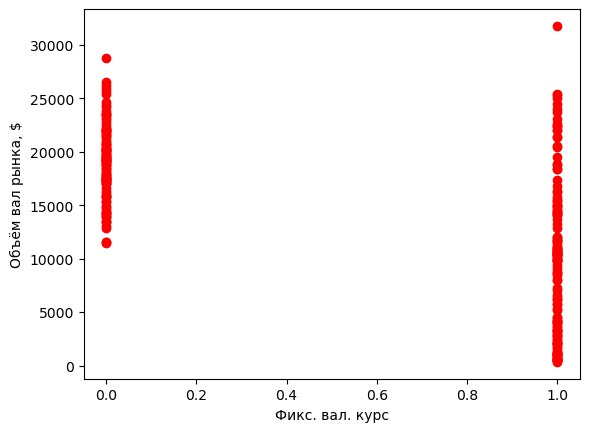

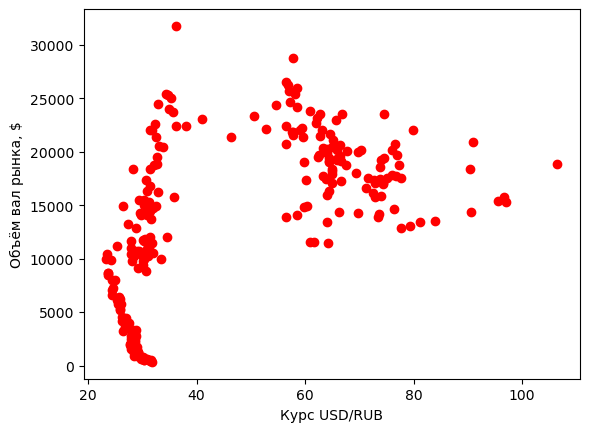

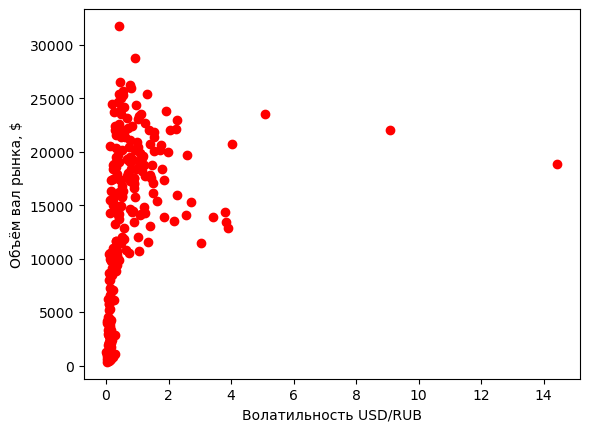

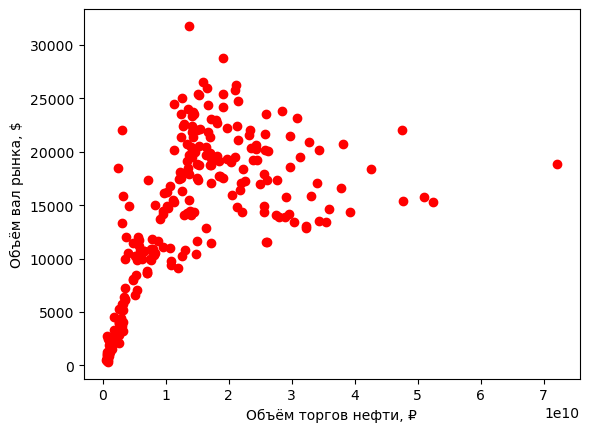

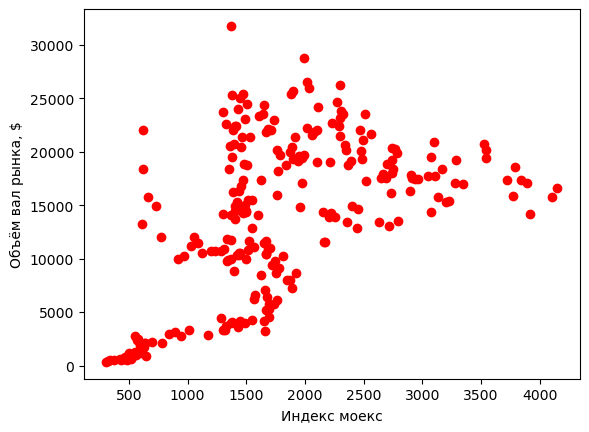

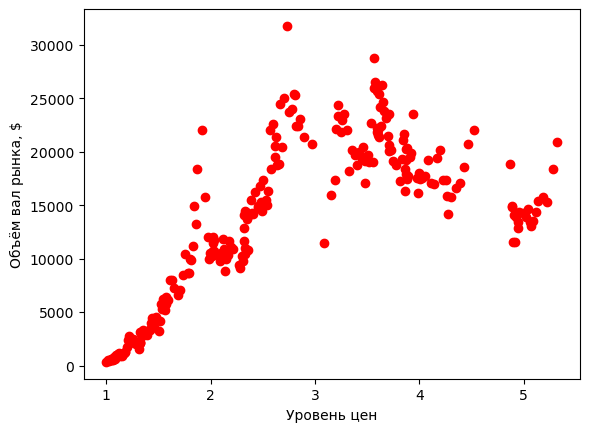

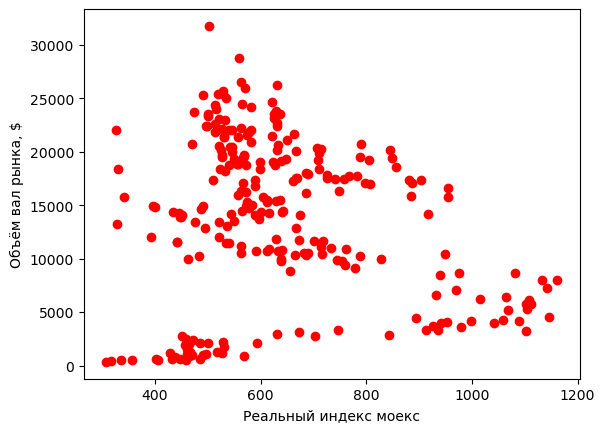

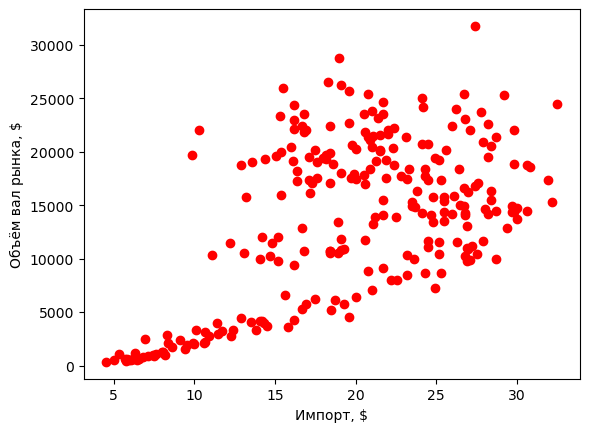

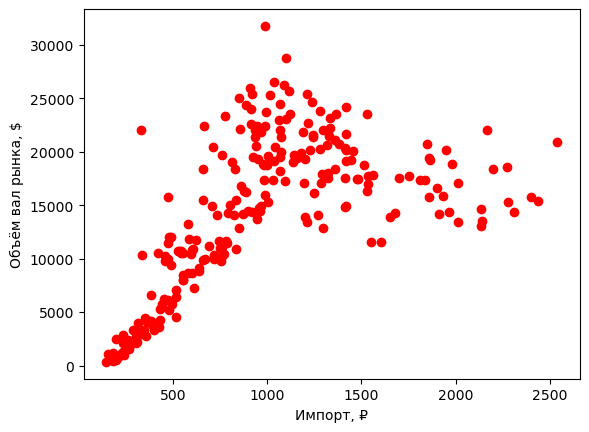

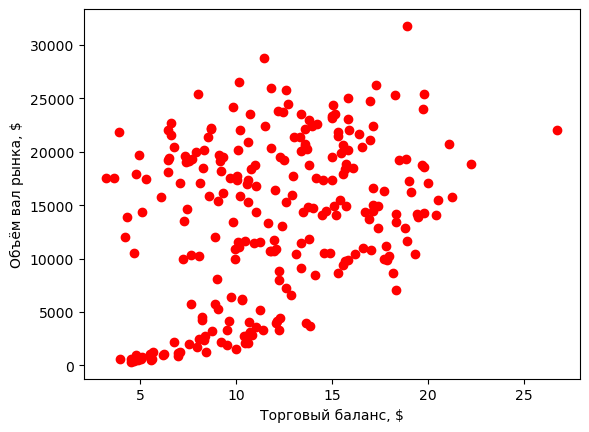

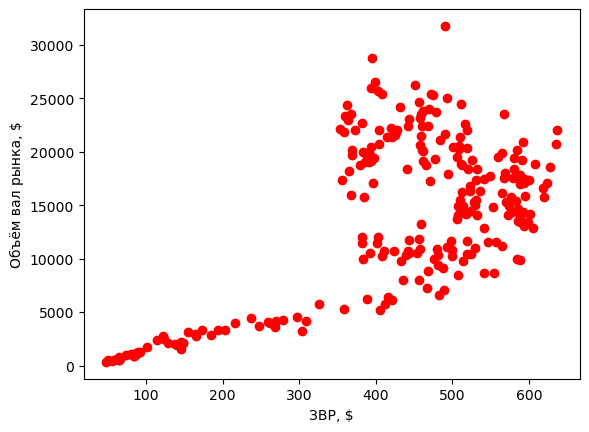

In [143]:
for column in df_merged.columns:
    if column != 'Объём вал рынка, $' and column != 'Дата':
        plt.scatter(df_merged[column], df_merged['Объём вал рынка, $'], color='red')  
        plt.ylabel('Объём вал рынка, $')
        plt.xlabel(column)
        plt.show()
        

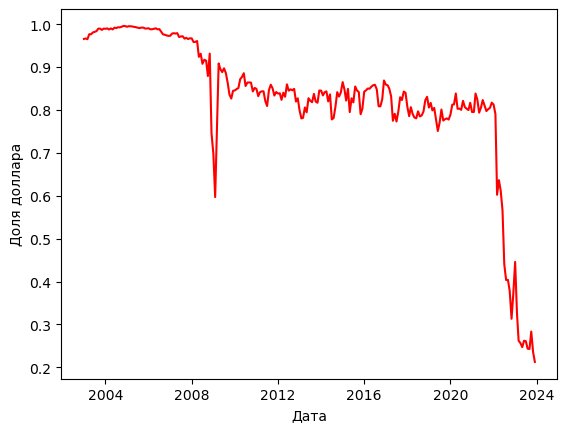

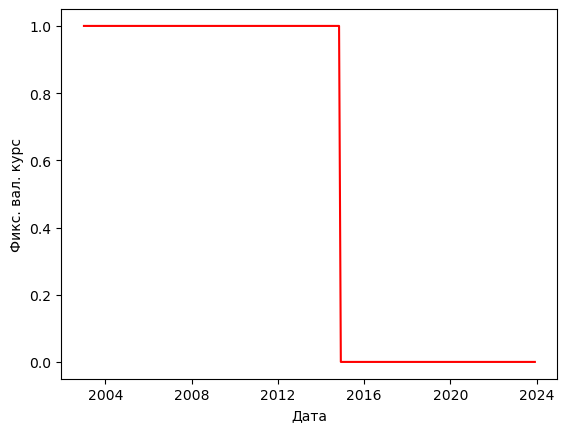

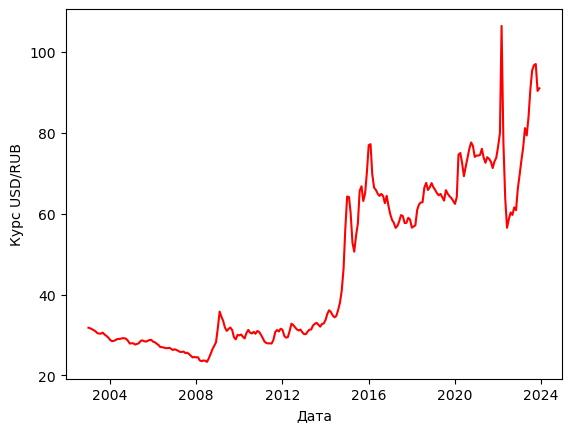

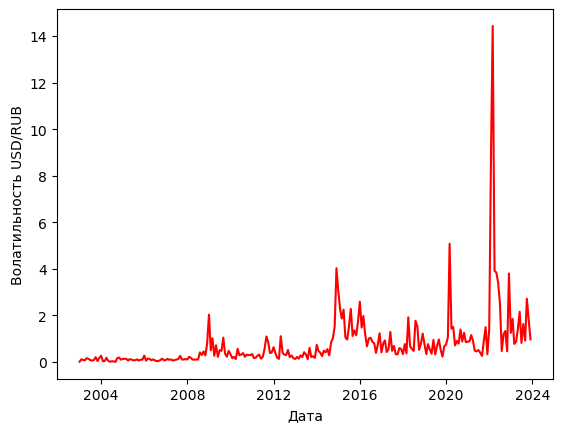

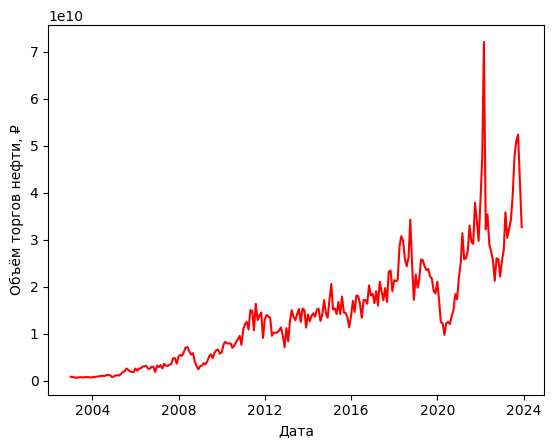

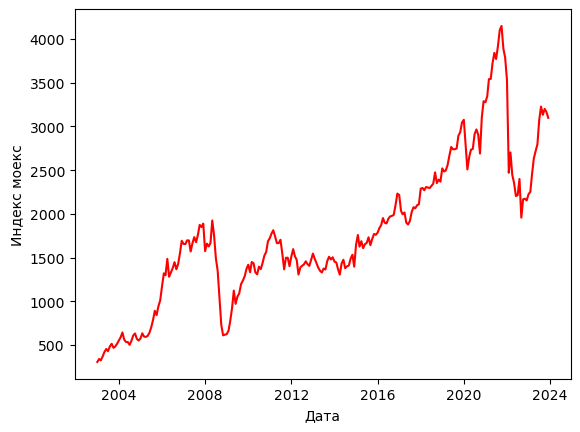

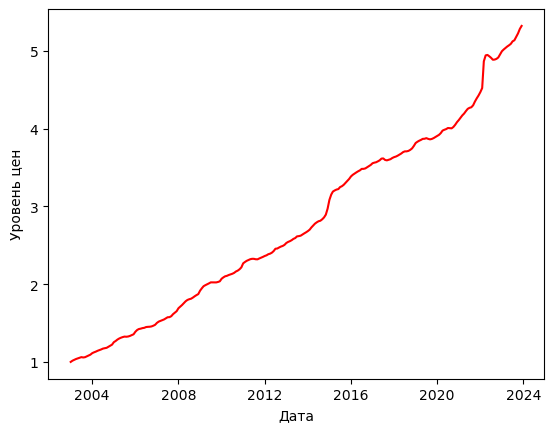

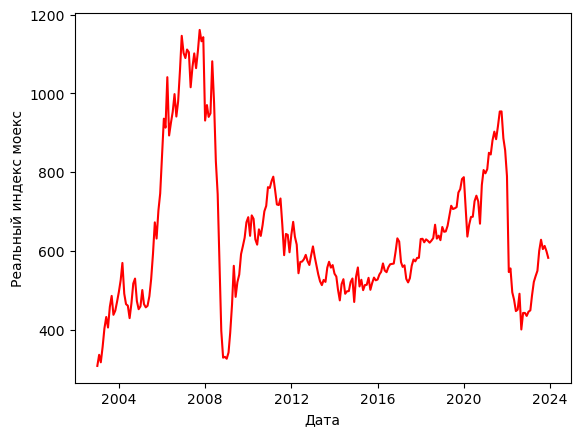

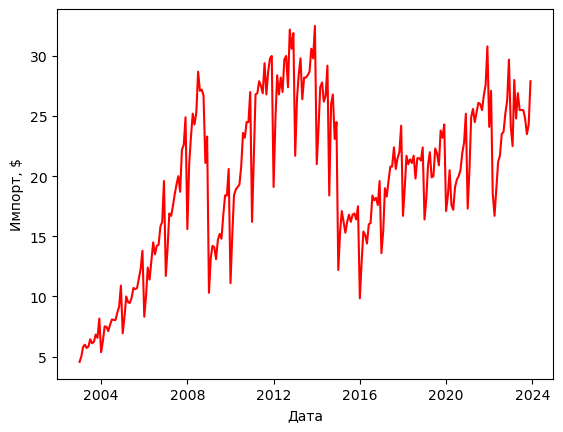

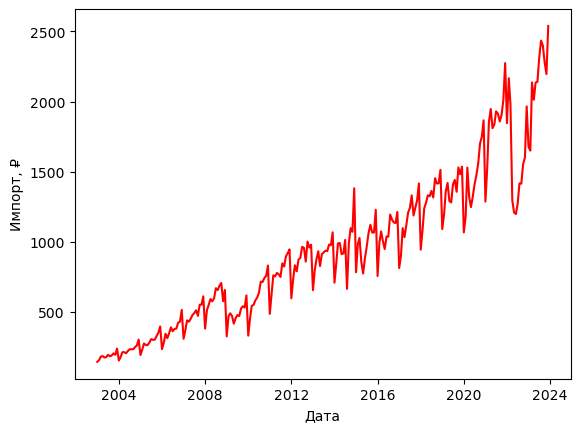

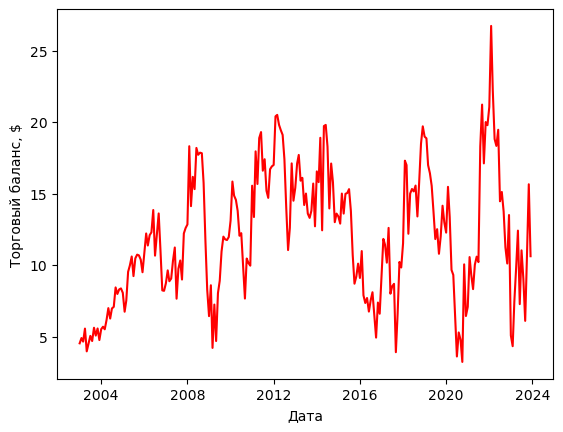

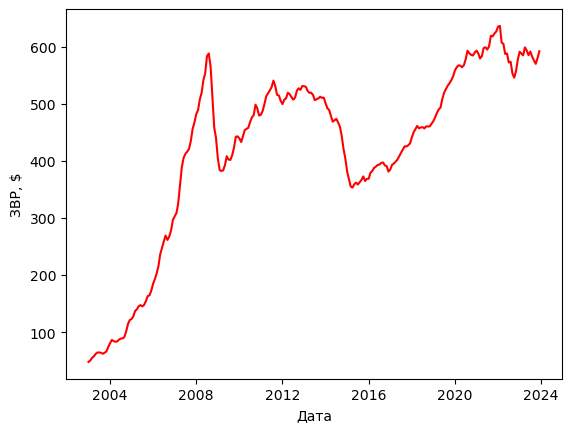

In [144]:
for column in df_merged.columns:
    if column != 'Объём вал рынка, $' and column != 'Дата':
        plt.plot(df_merged['Дата'], df_merged[column], color='red')  
        plt.ylabel(column)
        plt.xlabel('Дата')
        plt.show()

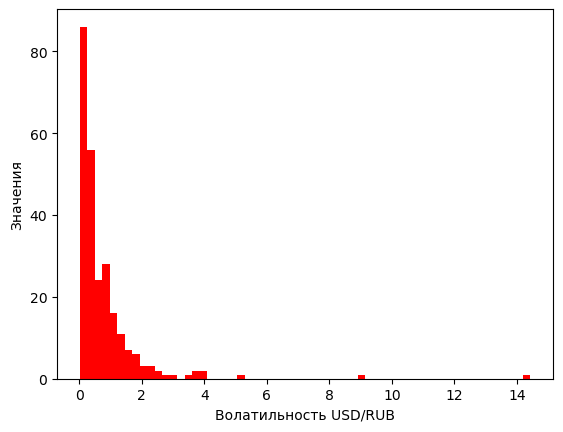

In [145]:
plt.hist(df_merged['Волатильность USD/RUB'], color='red', bins=60)
plt.ylabel('Значения')
plt.xlabel('Волатильность USD/RUB')
plt.show()

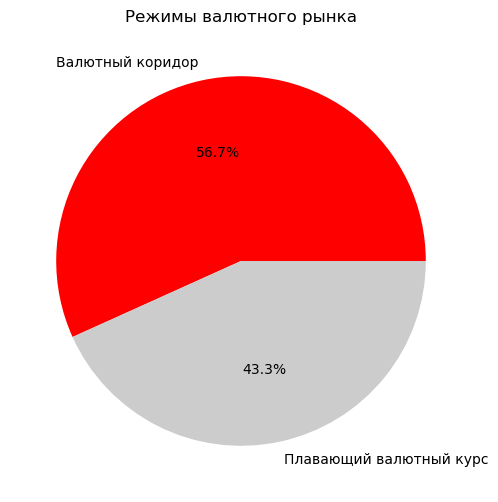

In [146]:
# Подсчитываем количество нулей и единиц
counts = df_merged['Фикс. вал. курс'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=['Валютный коридор', 'Плавающий валютный курс'], autopct='%1.1f%%', colors=['red', (0.8, 0.8, 0.8)])
plt.title('Режимы валютного рынка')
plt.show()